<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/images_ferramenta(H_augmented).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# /content/drive/MyDrive/Colab Notebooks/ferramenta/
path = "/content/drive/MyDrive/Colab Notebooks/Testing/"
# /content/drive/MyDrive/Colab Notebooks/Testing/feramentaImgs/
# images-train.tar.gz
# images-val.tar.gz

In [ ]:
os.chdir(path)

In [ ]:
import tarfile

with tarfile.open('images-val.tar.gz', 'r:gz') as tar_ref:
    tar_ref.extractall('validImages')

# Pre Processing

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(10),  # Randomly rotate the image by a maximum of 10 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class FragmentaDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir      
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()
        self.num_classes = len(self.dataset.classes)

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths
        
    # def __getitem__(self, index):
    #     image, label = self.dataset[index]
    #     return image, label

    def __getitem__(self, index):
        while True:
            try:
                image, label = self.dataset[index]
                return image, label
            except (UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Error loading image at index {index}: {e}")
                index += 1
                
    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/Testing/feramentaImgs/images-train/"
dataset = FragmentaDataset(data_dir)

In [ ]:
batch_size = 32
num_workers = 2
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# EDA

In [ ]:
class_length = dataset.class_lengths
class_labels = list(class_length.keys())

In [ ]:
from torchvision.transforms import ToPILImage

def plot_sample_images(dataset):
     

    # Create a grid layout based on the number of classes
    num_classes = len(class_length)
    grid_cols = 4  # Number of columns in the grid
    grid_rows = (num_classes + grid_cols - 1) // grid_cols  # Number of rows in the grid
    plt.figure(figsize=(10, 5 * grid_rows))

    # Create a transform to convert the tensor to PIL Image
    to_pil = ToPILImage()

    # Iterate over each class
    for i, class_label in enumerate(class_labels):
        # Get a random image index from the class
        image_index = np.random.choice(class_length[class_label])

        # Get the image and label from the dataset
        image, label = dataset[image_index]

        # Convert the image tensor to PIL Image
        image = to_pil(image)

        # Plot the image
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(image, interpolation='none')  # Use 'RGB' interpolation
        plt.title(class_label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


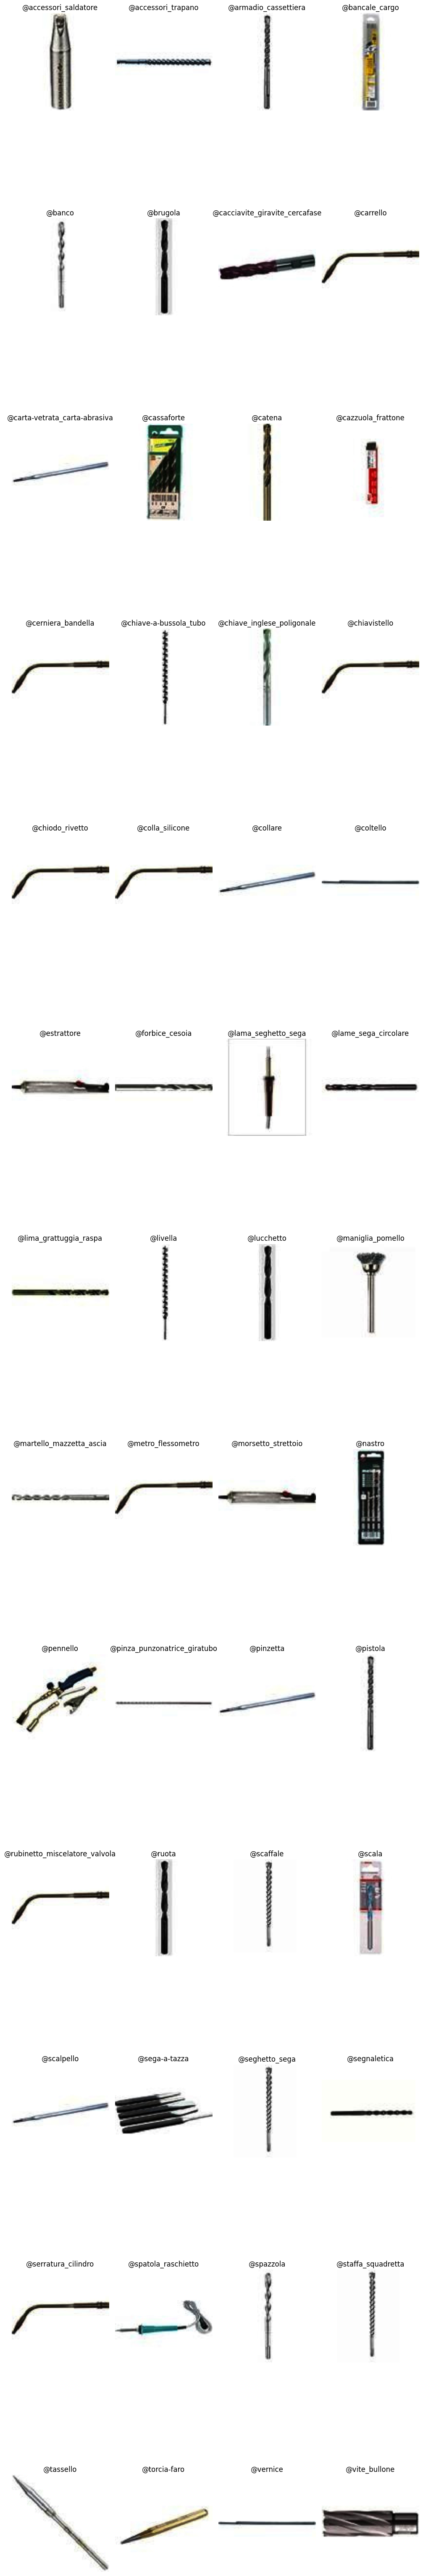

In [ ]:
plot_sample_images(dataset)

In [ ]:
class_lengths_dict = dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values()) 

Dictionary length: 52
Total sum: 22820
dict_values([65, 1971, 323, 56, 135, 199, 1115, 139, 679, 666, 132, 40, 119, 868, 1619, 47, 53, 220, 62, 48, 37, 1926, 289, 676, 290, 212, 483, 730, 767, 154, 83, 346, 61, 1202, 82, 156, 262, 143, 175, 374, 220, 564, 165, 1360, 260, 56, 89, 128, 381, 178, 113, 2302])


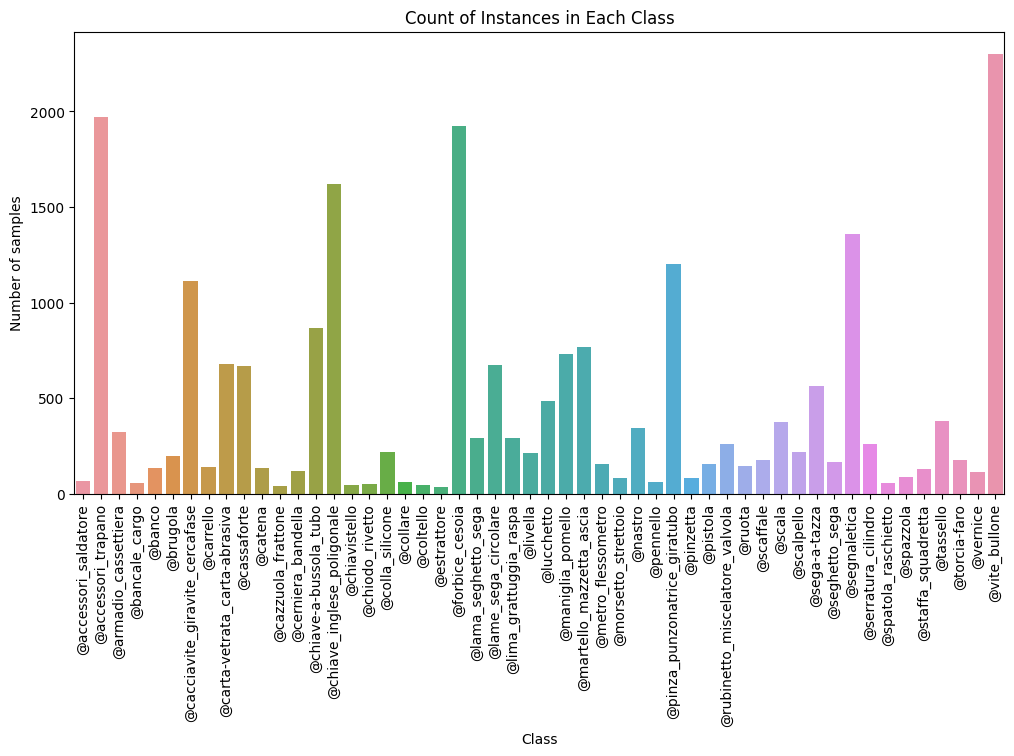

In [ ]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Create a count plot
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=class_counts)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class')
plt.show()

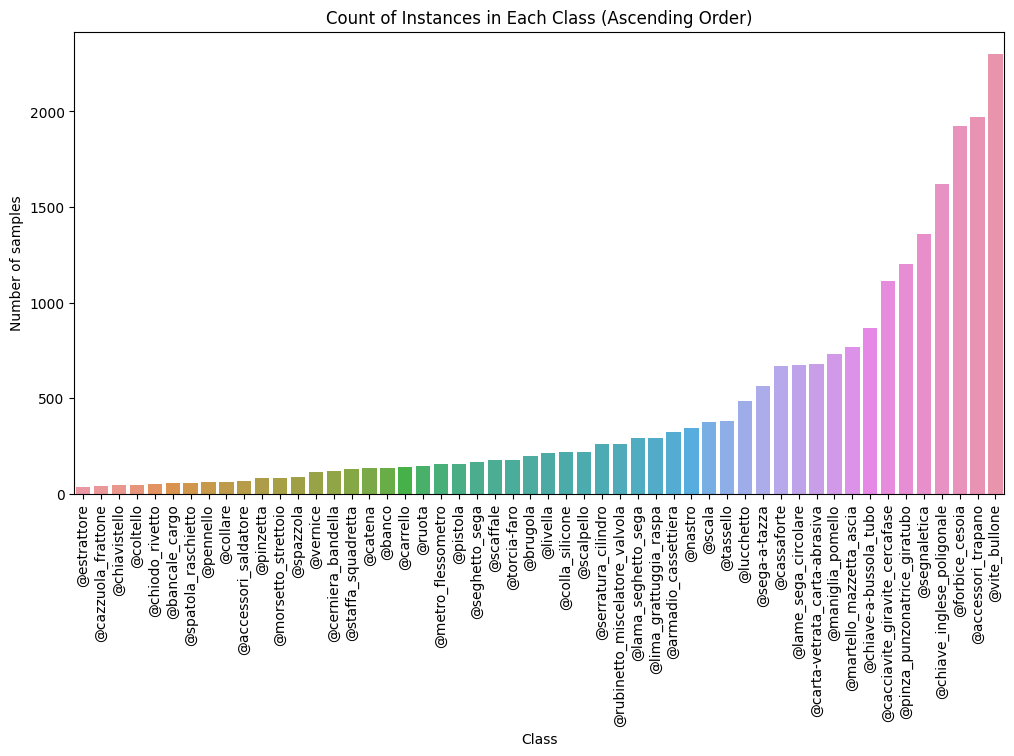

In [ ]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Sort the class labels and counts in ascending order
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k])
class_labels_sorted = [class_labels[i] for i in sorted_indices]
class_counts_sorted = [class_counts[i] for i in sorted_indices]

# Create a count plot with sorted data
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels_sorted, y=class_counts_sorted)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class (Ascending Order)')
plt.show()


# Loading ResNet-50

In [ ]:
resnet = models.resnet50(pretrained=True)
resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Fine Tuning

In [ ]:
num_classes = dataset.get_num_classes()
print("Number of classes:", num_classes)

Number of classes: 52


In [ ]:
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)

print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer and set the learning rate
learning_rate = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

num_epochs = 15
training_loss = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

for epoch in range(num_epochs):
    # Set the model to training mode
    resnet.train()
    
    running_loss = 0.0
    
    # Iterate over the data loader
    for images, labels in data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = resnet(images)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item() * images.size(0)
    
    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(data_loader.dataset)
    training_loss.append(epoch_loss)
    # Print the epoch loss
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

Epoch 1/15 Loss: 2.1423
Epoch 2/15 Loss: 1.3932
Epoch 3/15 Loss: 1.0747
Epoch 4/15 Loss: 0.8830
Epoch 5/15 Loss: 0.7319
Epoch 6/15 Loss: 0.6090
Epoch 7/15 Loss: 0.5200
Epoch 8/15 Loss: 0.4394
Epoch 9/15 Loss: 0.3711
Epoch 10/15 Loss: 0.3054
Epoch 11/15 Loss: 0.2618
Epoch 12/15 Loss: 0.2340
Epoch 13/15 Loss: 0.1832
Epoch 14/15 Loss: 0.1642
Epoch 15/15 Loss: 0.1513


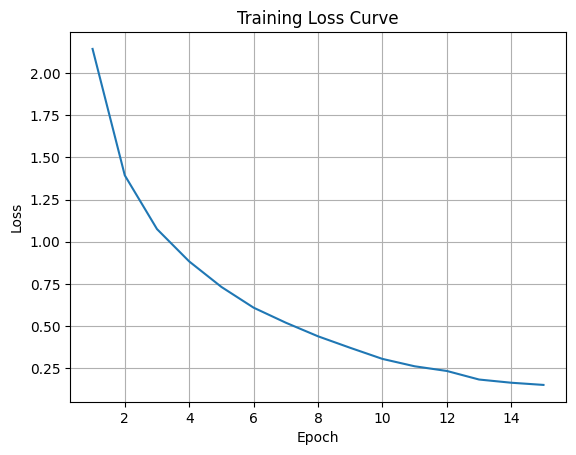

In [ ]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

In [ ]:
# /content/drive/MyDrive/Colab Notebooks/Testing/ResNet50model/
save_dir = "/content/drive/MyDrive/Colab Notebooks/Testing/ResNet50model/"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

save_path = os.path.join(save_dir, 'model.pth')  # Specify the complete path to the model file
torch.save(resnet.state_dict(), save_path)

# Validation

In [ ]:
# save_dir = '/content/drive/MyDrive/Colab Notebooks/ferramenta/models'
# load_path = os.path.join(save_dir, 'model.pth')

# # Create an instance of the ResNet model
# resnet = models.resnet50(pretrained=False)
# resnet.fc = nn.Linear(2048, 52)

# # Load the saved model parameters
# resnet.load_state_dict(torch.load(load_path))

# # Set the model to evaluation mode and respective device
# resnet.eval()
# resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# class ValidationDataset(torch.utils.data.Dataset):
#     def __init__(self, data_dir):
#         self.dataset = datasets.ImageFolder(data_dir, transform=transform)

#     def __getitem__(self, index):
#         image, label = self.dataset[index]
#         return image, label

#     def __len__(self):
#         return len(self.dataset)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(10),  # Randomly rotate the image by a maximum of 10 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# /content/drive/MyDrive/Colab Notebooks/Testing/validImages/images-val
# /content/drive/MyDrive/Colab Notebooks/ferramenta/validImages/images-val
valPath = "/content/drive/MyDrive/Colab Notebooks/Testing/validImages/images-val/"
val_dataset = FragmentaDataset(valPath)
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class_lengths_dict = val_dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values()) 

Dictionary length: 52
Total sum: 21869
dict_values([59, 1879, 345, 48, 132, 176, 1069, 148, 663, 642, 136, 35, 112, 842, 1555, 36, 51, 206, 59, 43, 33, 1926, 281, 634, 270, 196, 450, 697, 695, 146, 85, 331, 54, 1196, 73, 148, 238, 146, 142, 327, 203, 522, 157, 1352, 254, 37, 80, 116, 379, 159, 106, 2200])


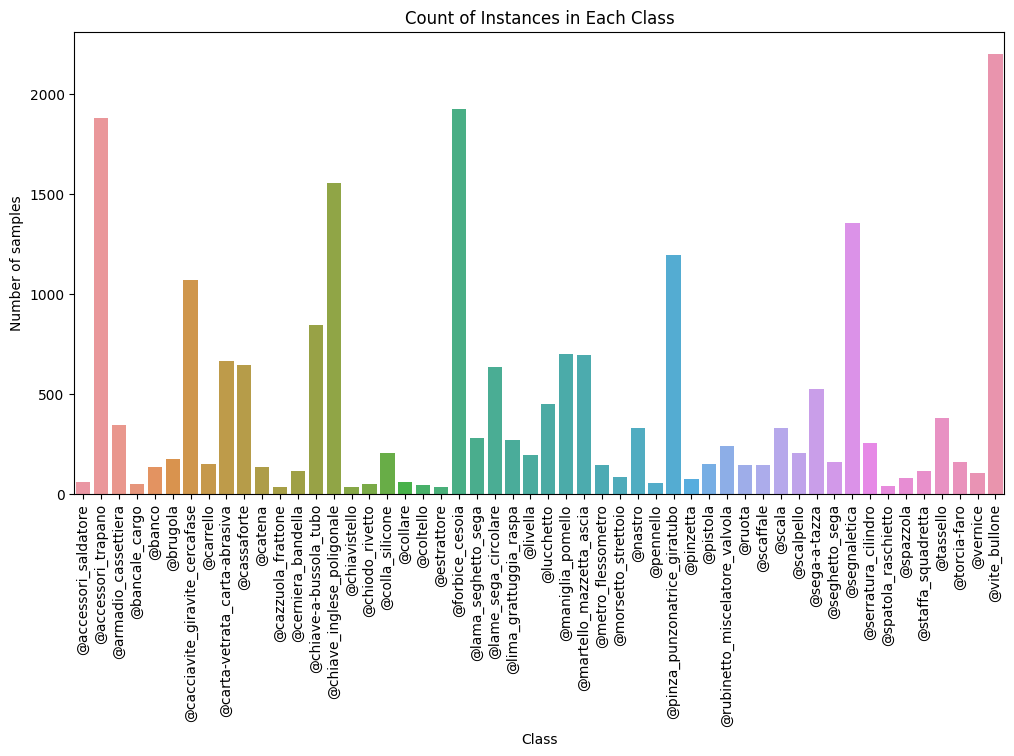

In [ ]:
#  Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Create a count plot
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=class_counts)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class')
plt.show()

In [ ]:
resnet.eval()

predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in validation_data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet(images)
        
        # Get the predicted labels
        _, predicted_label = torch.max(outputs, 1)
        
        # Store the predicted and true labels
        predicted_labels.extend(predicted_label.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

In [ ]:
# # Convert the lists to PyTorch tensors on the same device
# predicted_labels = torch.tensor(predicted_labels, device=device)
# true_labels = torch.tensor(true_labels, device=device)

In [ ]:
# true_labels = true_labels.cpu().numpy()
# predicted_labels = predicted_labels.cpu().numpy()

# Visualization

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8337829804746445
Precision: 0.8439936220467902
Recall: 0.8337829804746445
F1-score: 0.8314330939883323


In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.45      0.24      0.31        59
           1       0.84      0.94      0.88      1879
           2       0.85      0.77      0.81       345
           3       0.66      0.79      0.72        48
           4       0.99      0.85      0.91       132
           5       0.79      0.65      0.71       176
           6       0.89      0.89      0.89      1069
           7       0.91      0.86      0.88       148
           8       0.94      0.82      0.88       663
           9       0.87      0.98      0.92       642
          10       0.87      0.65      0.75       136
          11       0.94      0.49      0.64        35
          12       0.74      0.56      0.64       112
          13       0.94      0.75      0.83       842
          14       0.92      0.94      0.93      1555
          15       0.67      0.11      0.19        36
          16       0.87      0.39      0.54        51
          17       0.66    

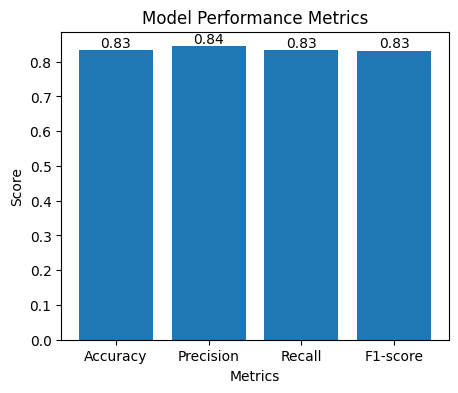

In [ ]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

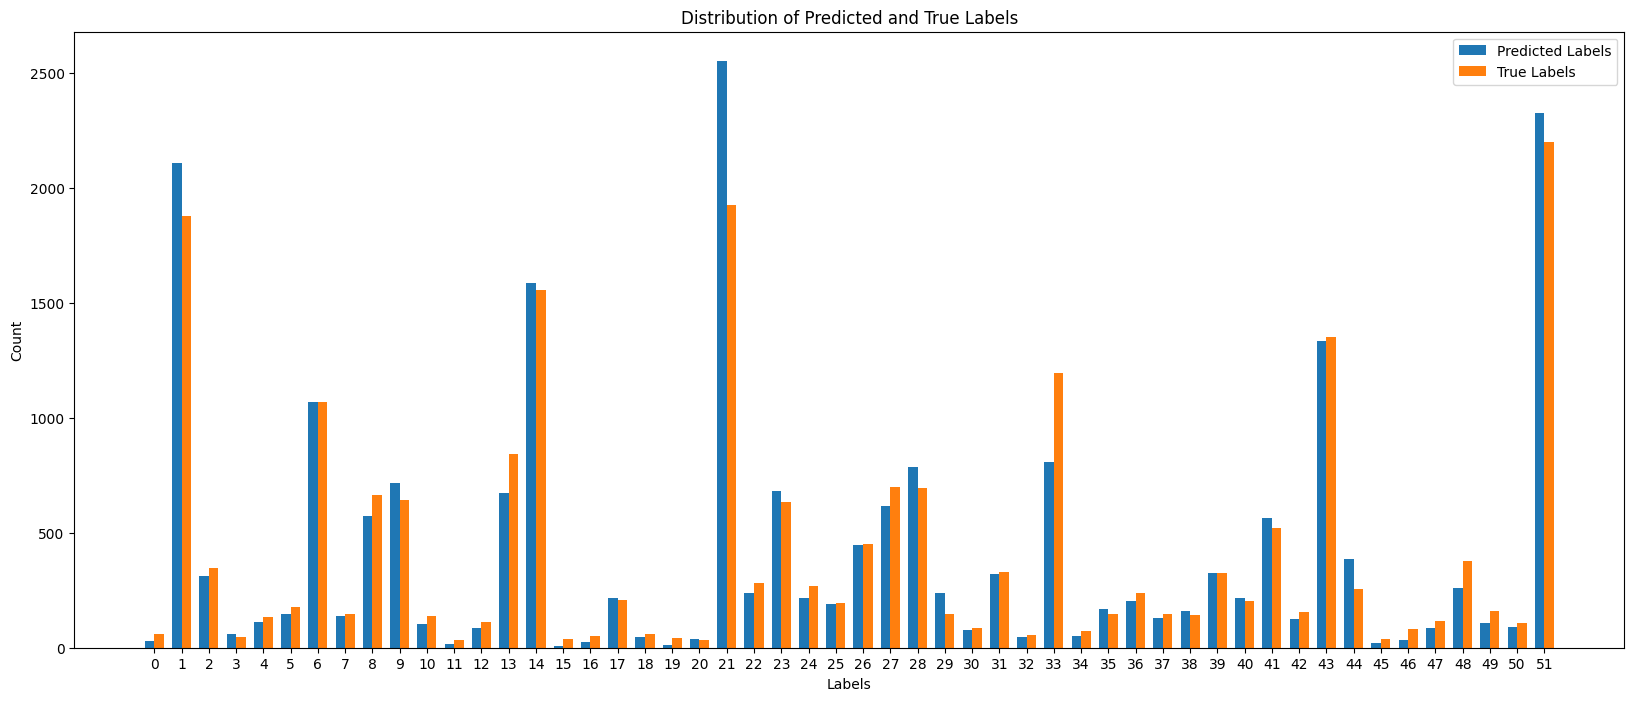

In [ ]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_labels)
true_counts = np.bincount(true_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_labels, true_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# GoogleNet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import torch.nn as nn
import torch.optim as optim
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from PIL import Image

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(10),  # Randomly rotate the image by a maximum of 10 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class FragmentaDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir      
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()
        self.num_classes = len(self.dataset.classes)

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths
        
    # def __getitem__(self, index):
    #     image, label = self.dataset[index]
    #     return image, label

    def __getitem__(self, index):
        while True:
            try:
                image, label = self.dataset[index]
                return image, label
            except (UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Error loading image at index {index}: {e}")
                index += 1
                
    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/Testing/feramentaImgs/images-train/"
dataset = FragmentaDataset(data_dir)
num_workers = 2
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
googlenet = models.googlenet(pretrained=True)

In [ ]:
num_classes = len(data_loader.dataset.dataset.classes)  
googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, num_classes)
print(googlenet)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)
num_epochs = 15

In [ ]:
training_losses = []
googlenet.train()
# Loop over the dataset and train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = googlenet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader.dataset)
    training_losses.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

Epoch 1/15 Loss: 0.0632
Epoch 2/15 Loss: 0.0357
Epoch 3/15 Loss: 0.0266
Epoch 4/15 Loss: 0.0210
Epoch 5/15 Loss: 0.0173
Epoch 6/15 Loss: 0.0143
Epoch 7/15 Loss: 0.0120
Epoch 8/15 Loss: 0.0103
Epoch 9/15 Loss: 0.0087
Epoch 10/15 Loss: 0.0071
Epoch 11/15 Loss: 0.0062
Epoch 12/15 Loss: 0.0053
Epoch 13/15 Loss: 0.0044
Epoch 14/15 Loss: 0.0037
Epoch 15/15 Loss: 0.0032


In [ ]:
# /content/drive/MyDrive/Colab Notebooks/ferramenta/models
# /content/drive/MyDrive/Colab Notebooks/Testing/GoogleNetmodelHaugment/
save_dir = '/content/drive/MyDrive/Colab Notebooks/Testing/GoogleNetmodel_H_augment/'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

save_path = os.path.join(save_dir, 'googleNet.pth')  # Specify the complete path to the model file
torch.save(googlenet.state_dict(), save_path)

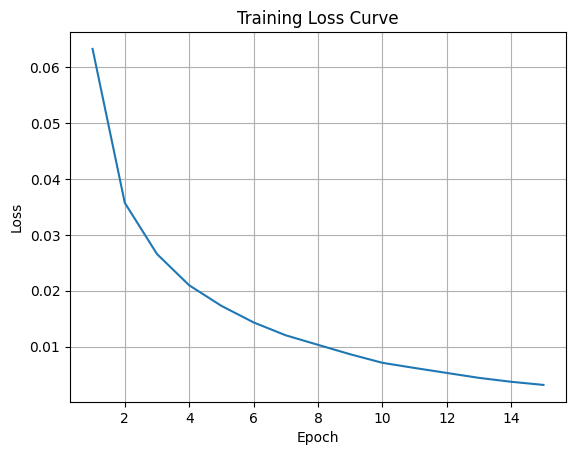

In [ ]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(10),  # Randomly rotate the image by a maximum of 10 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.dataset = datasets.ImageFolder(data_dir, transform=val_transform)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
valPath = "/content/drive/MyDrive/Colab Notebooks/Testing/validImages/images-val/"
val_dataset = ValidationDataset(valPath)
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize counters
# true_positives = 0
# false_positives = 0
# false_negatives = 0
# true_negatives = 0

predicted_labels = []
true_labels = []

# Evaluation loop
googlenet.eval()
with torch.no_grad():
    for images, labels in validation_data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = googlenet(images)
        _, predicted = torch.max(outputs, 1)
        
        predicted_labels.extend(predicted.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())
        # Update counts
        # true_positives += torch.sum(predicted == labels).item()
        # false_positives += torch.sum(predicted > labels).item()
        # false_negatives += torch.sum(predicted < labels).item()
        # true_negatives += torch.sum(predicted != labels).item()

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8843568521651654
Precision: 0.8839111791746366
Recall: 0.8843568521651654
F1-score: 0.882310640065629


In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.88      0.25      0.39        59
           1       0.91      0.95      0.93      1879
           2       0.92      0.88      0.90       345
           3       0.93      0.90      0.91        48
           4       0.94      0.96      0.95       132
           5       0.79      0.76      0.77       176
           6       0.95      0.93      0.94      1069
           7       0.90      0.90      0.90       148
           8       0.88      0.93      0.90       663
           9       0.93      0.97      0.95       642
          10       0.83      0.83      0.83       136
          11       0.81      0.63      0.71        35
          12       0.67      0.75      0.71       112
          13       0.83      0.92      0.87       842
          14       0.95      0.97      0.96      1555
          15       0.82      0.39      0.53        36
          16       0.80      0.47      0.59        51
          17       0.76    

In [ ]:
# Calculate the accuracy
# accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

# # Calculate the precision, recall, and F1 score
# precision = true_positives / (true_positives + false_positives)
# recall = true_positives / (true_positives + false_negatives)
# f1_score = 2 * (precision * recall) / (precision + recall)

# # Print the evaluation metrics
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.8976
Precision: 0.9416
Recall: 0.9375
F1 Score: 0.9395


In [ ]:
# confusion_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

# print("Confusion Matrix:")
# print(confusion_matrix)

Confusion Matrix:
[[ 1289   621]
 [  668 10015]]


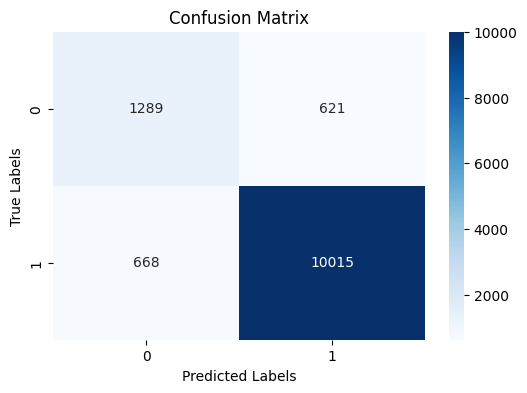

In [ ]:
# plt.figure(figsize=(6, 4))
# labels = []
# sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

# # Set the axis labels and title
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')

# # Show the plot
# plt.show()

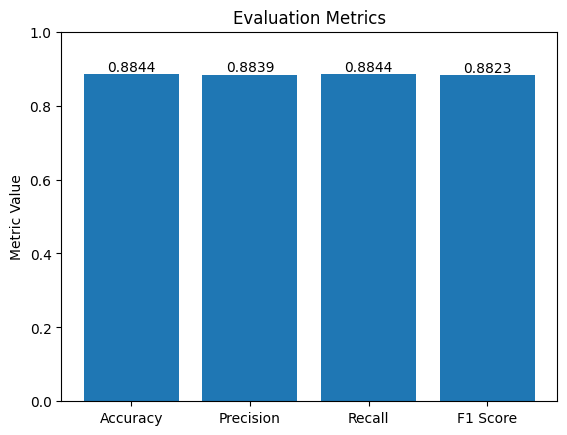

In [ ]:
# Define the labels for the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Define the values for each metric
values = [accuracy, precision, recall, f1]

fig, ax = plt.subplots()
bars = ax.bar(metrics, values)
plt.ylim([0, 1])  # Set the y-axis limit to range from 0 to 1
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics')

# Add the metric scores on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()

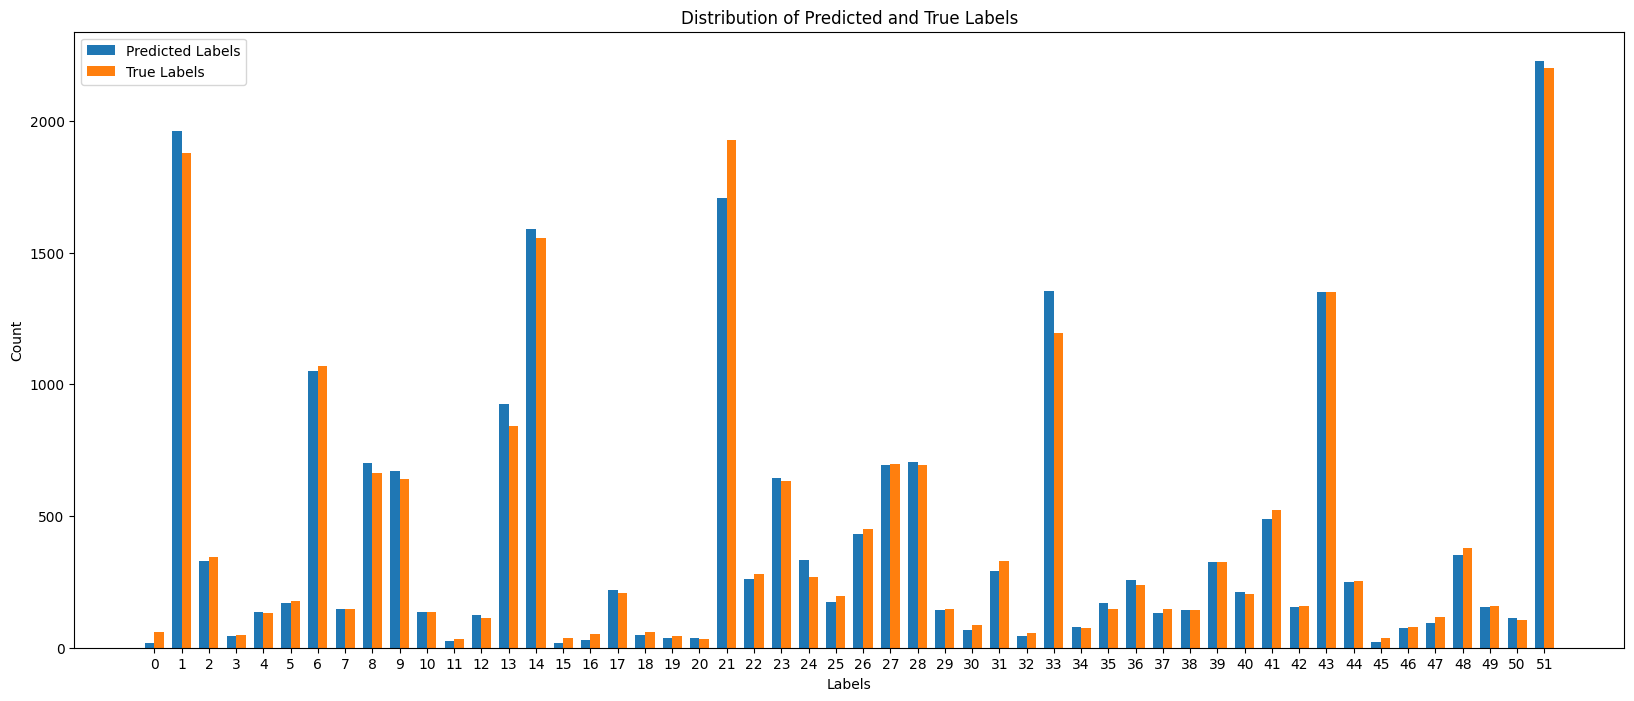

In [ ]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_labels)
true_counts = np.bincount(true_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_labels, true_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()